In [41]:
import keras
from keras.layers import Dense, Dropout, MaxPool2D, Conv2D, Flatten, Concatenate, Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [42]:
def inception_block(x,f):
  t1 = Conv2D(f[0],1,activation="relu")(x)
  
  t2 = Conv2D(f[1],1,activation="relu")(x)
  t2 = Conv2D(f[2],3,padding="same",activation="relu")(t2)
  
  t3 = Conv2D(f[3],1,activation="relu")(x)
  t3 = Conv2D(f[4],5,padding="same",activation="relu")(t3)

  t4 = MaxPool2D(3,1,padding="same")(x)
  t4 = Conv2D(f[5],1,activation="relu")(t4)

  output = Concatenate()([t1,t2,t3,t4])
  return output

In [43]:
input = Input(shape = (224,224,3))
x = Conv2D(64, 7, strides = 2, padding = "same", activation = "relu")(input)
x = MaxPool2D(3, 2, padding="same")(x)
x = Conv2D(64, 1, activation = "relu")(x)
x = Conv2D(192, 3, padding="same", activation = "relu")(x)
x = MaxPool2D(3, 2, padding="same")(x)
x = inception_block(x, [64,96,128,16,32,32])

In [44]:
from keras.preprocessing.image import ImageDataGenerator

In [45]:
train_generator = ImageDataGenerator(rescale = 1/255, horizontal_flip = False, validation_split = 0.2)
test_generator = ImageDataGenerator(rescale = 1/255, horizontal_flip = False)

In [46]:
train_path = "../input/dogs-vs-cats/train"
test_path = "../input/dogs-vs-cats/test"

train_dataset = train_generator.flow_from_directory(
    train_path,
    batch_size = 128,
    target_size = (224,224),
    class_mode = "binary",
    color_mode = "rgb",
    subset = "training")

validation_dataset = train_generator.flow_from_directory(
    train_path,
    batch_size = 128,
    target_size = (224,224),
    class_mode = "binary",
    color_mode = "rgb",
    subset = "validation")

test_dataset = train_generator.flow_from_directory(
    test_path,
    batch_size = 128,
    target_size = (224,224),
    class_mode = "binary",
    color_mode = "rgb",)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [47]:
import matplotlib.pyplot as plt
import numpy as np
train_dataset[0][0].shape

(128, 224, 224, 3)

In [48]:
model = InceptionV3(input_shape = (224,224,3), weights = "imagenet", include_top = False)

In [49]:
batch_size = 128
num_classes = 1


for layers in model.layers:
  layers.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512,activation="relu")(x)
prediction = Dense(num_classes,activation = "sigmoid")(x)
model = Model(model.input, prediction)
model.summary()
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_112[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [50]:
history = model.fit_generator(train_dataset, validation_data = validation_dataset, epochs = 3, shuffle = True)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
125/125 [==============================] - 100s 764ms/step - loss: 0.0643 - accuracy: 0.9773 - val_loss: 0.0456 - val_accuracy: 0.9835
Epoch 2/3
125/125 [==============================] - 93s 746ms/step - loss: 0.0324 - accuracy: 0.9887 - val_loss: 0.0445 - val_accuracy: 0.9830
Epoch 3/3
125/125 [==============================] - 93s 743ms/step - loss: 0.0304 - accuracy: 0.9886 - val_loss: 0.0490 - val_accuracy: 0.9840


In [51]:
model.evaluate_generator(test_dataset)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.03539125621318817, 0.9868000149726868]

In [52]:
model.save("inception_model.h5")

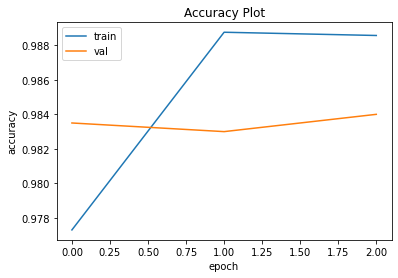

In [53]:
history = history.history
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title("Accuracy Plot")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","val"])
plt.savefig("accuracy.png")

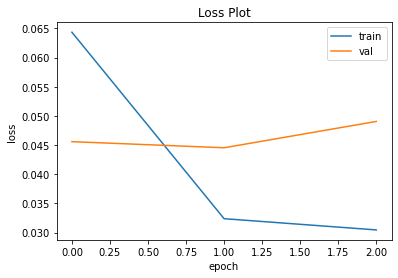

In [54]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Loss Plot")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","val"])
plt.savefig("loss.png")

In [55]:
!wget https://scx2.b-cdn.net/gfx/news/hires/2018/2-dog.jpg

--2022-03-02 06:51:20--  https://scx2.b-cdn.net/gfx/news/hires/2018/2-dog.jpg
Resolving scx2.b-cdn.net (scx2.b-cdn.net)... 185.93.1.247
Connecting to scx2.b-cdn.net (scx2.b-cdn.net)|185.93.1.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 415118 (405K) [image/jpeg]
Saving to: ‘2-dog.jpg.1’

2-dog.jpg.1         100%[===================>] 405.39K   967KB/s    in 0.4s    

2022-03-02 06:51:21 (967 KB/s) - ‘2-dog.jpg.1’ saved [415118/415118]



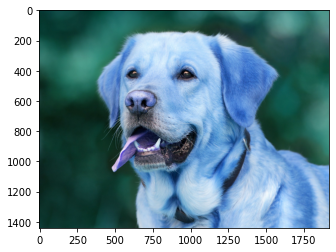

In [56]:
img = cv2.imread('2-dog.jpg')
image = cv2.resize(img, (224, 224))
plt.imshow(img)

In [57]:
model = load_model('inception_model.h5')

In [58]:
round(model.predict(np.array([image]))[0][0])

1

In [59]:
train_dataset.class_indices

{'cats': 0, 'dogs': 1}

In [60]:
y_pred = model.predict_generator(test_dataset)

In [61]:
pred = y_pred.argmax(axis = 1)

In [63]:
confusion_matrix(test_dataset.classes,pred)

array([[2500,    0],
       [2500,    0]])